In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ====== MODELO LUMEN ======
class LUMENModel(nn.Module):
    def __init__(self, input_dims=(10, 8, 6)):
        super(LUMENModel, self).__init__()
        self.gen_fc1 = nn.Linear(input_dims[0], 32)
        self.gen_fc2 = nn.Linear(32, 16)
        self.gen_softmax = nn.Softmax(dim=1)

        self.amb_fc1 = nn.Linear(input_dims[1], 32)
        self.amb_fc2 = nn.Linear(32, 16)
        self.amb_softmax = nn.Softmax(dim=1)

        self.rel_fc1 = nn.Linear(input_dims[2], 32)
        self.rel_fc2 = nn.Linear(32, 16)
        self.rel_softmax = nn.Softmax(dim=1)

        self.fusion_fc1 = nn.Linear(16 * 3, 64)
        self.fusion_fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x_gen, x_amb, x_rel):
        g = F.relu(self.gen_fc1(x_gen))
        g = F.relu(self.gen_fc2(g))
        g = self.gen_softmax(g)

        a = F.relu(self.amb_fc1(x_amb))
        a = F.relu(self.amb_fc2(a))
        a = self.amb_softmax(a)

        r = F.relu(self.rel_fc1(x_rel))
        r = F.relu(self.rel_fc2(r))
        r = self.rel_softmax(r)

        combined = torch.cat([g, a, r], dim=1)
        x = F.relu(self.fusion_fc1(combined))
        x = F.relu(self.fusion_fc2(x))
        x = torch.sigmoid(self.output(x))
        return x, g, a, r

In [7]:
# ====== CARREGAR DADOS E MODELO ======
df = pd.read_csv("data/data.csv")
X = df.drop("TARGET", axis=1).values
X_gen = torch.tensor(X[:, :10], dtype=torch.float32)
X_amb = torch.tensor(X[:, 10:18], dtype=torch.float32)
X_rel = torch.tensor(X[:, 18:24], dtype=torch.float32)

model = LUMENModel()
model.load_state_dict(torch.load(r'C:\Users\CruellyzoN\OneDrive\Documentos\LUMEN\models\lumen.pt'))
model.eval()

C:\Users\CruellyzoN\AppData\Local\Temp\ipykernel_11016\186954487.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\CruellyzoN\O

LUMENModel(
  (gen_fc1): Linear(in_features=10, out_features=32, bias=True)
  (gen_fc2): Linear(in_features=32, out_features=16, bias=True)
  (gen_softmax): Softmax(dim=1)
  (amb_fc1): Linear(in_features=8, out_features=32, bias=True)
  (amb_fc2): Linear(in_features=32, out_features=16, bias=True)
  (amb_softmax): Softmax(dim=1)
  (rel_fc1): Linear(in_features=6, out_features=32, bias=True)
  (rel_fc2): Linear(in_features=32, out_features=16, bias=True)
  (rel_softmax): Softmax(dim=1)
  (fusion_fc1): Linear(in_features=48, out_features=64, bias=True)
  (fusion_fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
# ====== SELECIONAR UMA AMOSTRA ======
i = 0  # índice da amostra
xg = X_gen[i:i+1]
xa = X_amb[i:i+1]
xr = X_rel[i:i+1]

with torch.no_grad():
    y_pred, g_vec, a_vec, r_vec = model(xg, xa, xr)

print(f"Predição final: {y_pred.item():.4f}")

Predição final: 0.3689


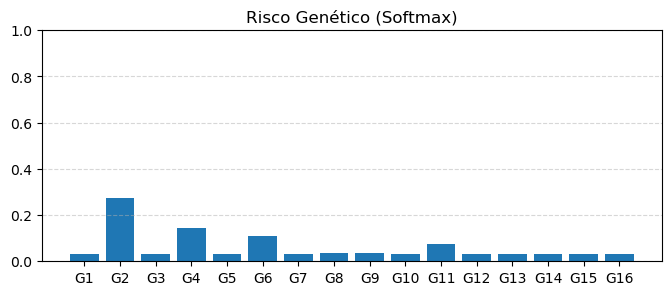

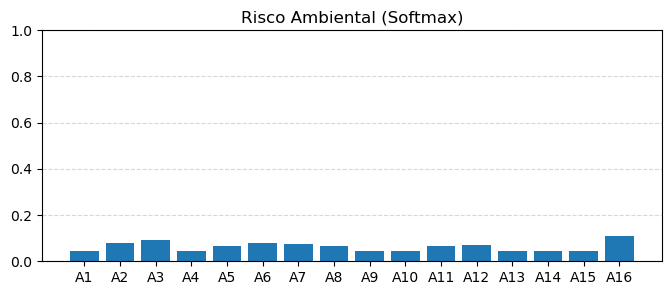

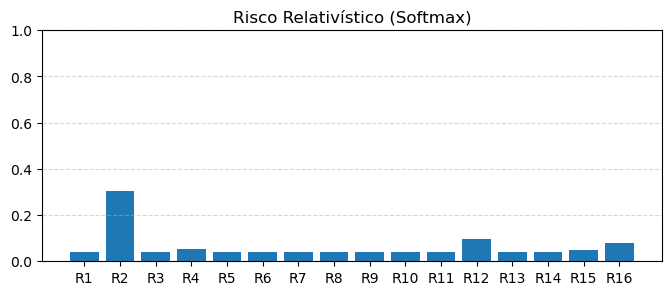

In [5]:
# ====== VISUALIZAÇÃO DOS VETORES ======
def plot_vector(vetor, title, labels):
    plt.figure(figsize=(8, 3))
    plt.bar(range(len(vetor)), vetor, tick_label=labels)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()

plot_vector(g_vec[0].numpy(), "Risco Genético (Softmax)", [f"G{i+1}" for i in range(16)])
plot_vector(a_vec[0].numpy(), "Risco Ambiental (Softmax)", [f"A{i+1}" for i in range(16)])
plot_vector(r_vec[0].numpy(), "Risco Relativístico (Softmax)", [f"R{i+1}" for i in range(16)])